PROJECT 11: Uncertainty-Aware Road Obstacle Identification

Abstract: Reliable road obstacle identification is a critical requirement for the safe operation of autonomous
driving systems. Traditional object detection methods often struggle to recognize unexpected or unknown
obstacles, as they are typically limited to predefined categories. The ability to detect obstacles beyond
known classes, particularly in dynamic and complex environments, is essential for the safety of autonomous
vehicles. Recent advancements in semantic segmentation, anomaly detection, and uncertainty quantification
offer new avenues to improve detection accuracy and reliability, enabling systems to recognize both known
and unknown road obstacles. Such uncertainty-aware methods provide formal statistical guarantees on the
reliability of predictions, a crucial aspect for ensuring safe and robust decision-making in real-world driving
conditions.

Dataset: Cityscapes, LostAndFound, RoadAnomaly, Fishyscapes

# Imports

In [ ]:
!pip install pytorch-lightning segmentation-models-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torchmetrics --quiet

In [ ]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import kagglehub
import os

In [ ]:
import zipfile
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Any, Callable, Dict, List, Optional, Union, Tuple

from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp

from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
from torchmetrics.classification import BinaryJaccardIndex

In [ ]:
import matplotlib.colors as mcolors
from torchvision.models.segmentation import deeplabv3_resnet50

import torch.nn.functional as F
from torchvision.transforms.functional import gaussian_blur
import torch.optim as optim

In [ ]:
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.data import Dataset
from glob import glob
import torchvision.transforms as T

In [ ]:
import random
from torchvision.transforms.functional import to_tensor, normalize
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve

In [ ]:
!pip install -U gdown
!gdown --folder https://drive.google.com/drive/folders/1f8Pxl8iGoRym0cagDvaweP3lbBNO2tuk?usp=sharing -O /content/cityscapes --fuzzy

Retrieving folder contents
Processing file 1vKuWcc66WqiIGUPDVaha7C8w1sd13G_a gtFine.zip
Processing file 1itO7zdz4jaPL6OjuG5FvV-9tFECrdbj4 leftImg8bit.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1vKuWcc66WqiIGUPDVaha7C8w1sd13G_a
From (redirected): https://drive.google.com/uc?id=1vKuWcc66WqiIGUPDVaha7C8w1sd13G_a&confirm=t&uuid=ee993eb6-d1f9-4181-bd09-9d5a45145531
To: /content/cityscapes/gtFine.zip
100% 261M/261M [00:06<00:00, 41.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1itO7zdz4jaPL6OjuG5FvV-9tFECrdbj4
From (redirected): https://drive.google.com/uc?id=1itO7zdz4jaPL6OjuG5FvV-9tFECrdbj4&confirm=t&uuid=a9f6c2d6-fc1a-421c-971e-8b5b33554e63
To: /content/cityscapes/leftImg8bit.zip
100% 11.6G/11.6G [05:53<00:00, 32.8MB/s]
Download completed


In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1frfml1PU7hENftQ-cvY-gx0QYi0OcSnQ?usp=sharing -O /content/roadanomaly --fuzzy

Retrieving folder contents
Processing file 1kzqkXss6m7lCQkU5RwHyB9pY0Hw_JQj5 frames.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1kzqkXss6m7lCQkU5RwHyB9pY0Hw_JQj5
To: /content/roadanomaly/frames.zip
100% 23.5M/23.5M [00:00<00:00, 32.8MB/s]
Download completed


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

In [ ]:
def convert_label_to_multilabel_one_hot(label, dataset):
    """
    Converts 2D label mask [H, W] with Cityscapes original IDs into a multi-label one-hot encoding tensor [8, H, W].
    The last channel (index 7) corresponds to the 'object' auxiliary channel.
    """

    LABEL_TO_MACRO_IDX = {}

    for original_id, (macro_class, is_object) in CLASS_MAPPING.items():
        if macro_class is not None:
            LABEL_TO_MACRO_IDX[original_id] = MACRO_CLASSES[macro_class]
        else:
            # only object channel will be set
            LABEL_TO_MACRO_IDX[original_id] = None

    height, width = label.shape
    multilabel = torch.zeros((8, height, width), dtype=torch.float32)

    if dataset == "cityscapes":
        # Iterate over each original class ID in CLASS_MAPPING
        for original_id, (_, is_object) in CLASS_MAPPING.items():

            # Boolean mask of where the input label equals the current original class ID
            mask = (label == original_id)

            # Look up the macro-class index for this class ID
            macro_idx = LABEL_TO_MACRO_IDX[original_id]

            # If this class maps to a macro-class we set to 1 the pixel in the corresponding channel
            if macro_idx is not None:
                multilabel[macro_idx][mask] = 1.0

            # If this class is considered an 'object' we also set the 'object' channel (index 7) to 1
            if is_object:
                multilabel[MACRO_CLASSES["object"]][mask] = 1.0

    elif dataset == "lostandfound":
        height, width = label.shape
        multilabel = torch.zeros((8, height, width), dtype=torch.float32)

        road_mask = (label == 1)
        object_mask_1 = (label != 1)
        object_mask_2 = (label != 0)
        object_mask = object_mask_1 == object_mask_2


        multilabel[MACRO_CLASSES["road"]][road_mask] = 1.0
        multilabel[MACRO_CLASSES["object"]][object_mask] = 1.0

    elif dataset == "roadanomaly":
        height, width = label.shape
        multilabel = torch.zeros((8, height, width), dtype=torch.float32)

        anomaly_mask = (label != 0)  # Anomaly pixels are not equal to 0

        multilabel[MACRO_CLASSES["object"]][anomaly_mask] = 1.0

    elif dataset == "fishyscapes":
          height, width = label.shape
          multilabel = torch.zeros((8, height, width), dtype=torch.float32)

          # Fishyscapes with labels 0 = background, 1 = anomaly
          anomaly_mask = (label == 1)
          multilabel[MACRO_CLASSES["object"]][anomaly_mask] = 1.0


    else:
        print("you have to choose a dataset\n ")

    # multi-label one-hot tensor of shape [8, H, W]
    return multilabel




In [ ]:
def unknown_objectness_score(preds):
    """
    Computes the unknown objectness score (UOS) from the model predictions. The UOS is computed as follows:

    UOS = obj_scores * Π(1 - class_scores_i)  for i in number of classes
    """
    obj_scores = preds[:, 7, :, :]
    class_scores = preds[:, 0:7, :, :]

    unknown_scores = torch.prod(1 - class_scores, dim=1)
    uos = obj_scores * unknown_scores

    # unknown objectness scores of shape [B, H, W]
    return uos

In [ ]:
def get_boundary_mask_batch(label_masks, kernel_size=3, iterations=2):
    """
    Computes the boundary mask of shape [B, H, W], as difference between dilated and eroded regions, for a batch of label masks.

    kernel_size: Size of the kernel to use.
    iterations: Number of times to apply dilation and erosion (higher values result in thicker boundaries).
    """

    if label_masks.dim() == 3:
        label_masks = label_masks.unsqueeze(1)  # [B, 1, H, W]

    label_masks = label_masks.float()

    # Define kernel
    device = label_masks.device
    kernel = torch.ones((1, 1, kernel_size, kernel_size), device=device)

    padding = kernel_size // 2

    #Dilation
    dilated = label_masks
    for _ in range(iterations):
        dilated = F.conv2d(dilated, kernel, padding=padding)
        dilated = (dilated > 0).float()

    #Erosion
    eroded = label_masks
    for _ in range(iterations):
        eroded = F.conv2d(eroded, kernel, padding=padding)
        eroded = (eroded == kernel.numel()).float()

    # Compute boundary: difference between dilated and eroded regions
    boundary = (dilated != eroded).float()

    return boundary.squeeze(1).byte()  # Return shape [B, H, W], uint8

In [ ]:
def visualize_uos_with_conformal(test_image, uos_tensor, threshold):
    """
    Compute and visualize the UOS heatmap on the original image applying
    conformal threshold to detect unknown pixels.

    threshold: UOS threshold from calibration.
    """
    img = test_image.permute(1, 2, 0).cpu().numpy()
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    uos = uos_tensor.cpu().numpy()

    # Create binary mask of unknowns using conformal threshold
    unknown_mask = np.where(uos > threshold, uos, 0.0)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    img_np = test_image.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Unknown Objectness Score Heatmap")
    plt.imshow(uos, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Unknown Object Mask (Conformal Prediction)")
    plt.imshow(img_np)
    plt.imshow(unknown_mask, cmap='cool', alpha=0.5, vmin=0, vmax=1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def uos_heatmap(img_tensor, uos_tensor, threshold=0.5, alpha_val=0.5):
      """
    Compute and visualize the UOS heatmap on top of the original image

    threshold: UOS threshold from calibration.
    """

    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    uos = uos_tensor.cpu().numpy()
    uos = np.where(uos > threshold, uos, 0.0)

    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.imshow(uos, cmap='hot', alpha=alpha_val, vmin=0, vmax=1)
    plt.title("Unknown Objectness Score Heatmap")
    plt.colorbar(label="UOS score (0-1)")
    plt.axis('off')
    plt.show()

In [ ]:
def evaluate_detection_performance_metrics(model, dataloader, ignore_class=7, eps=1e-7, device="cpu"):
    """
    Evaluate segmentation model on dataloader, returning pixel accuracy, mean IoU, mean F1 (Dice).
    """
    model = model.to(device)
    model.eval()
    pixel_acc_sum = 0
    iou_sum = 0
    f1_sum = 0
    n_batches = 0

    with torch.no_grad():
        for images, masks, _ in dataloader:
            images = images.to(device).float()
            masks = masks.to(device)

            preds_logits = model(images)

            # Pixel Accuracy
            # Exclude ignore_class channel and take argmax
            preds = preds_logits[:, :ignore_class, :, :]
            pred_classes = torch.argmax(preds, dim=1)

            if masks.dim() == 4 and masks.shape[1] > 1:
                # Convert one-hot mask [B,C,H,W] to class indices [B,H,W]
                masks = torch.argmax(masks, dim=1)

            valid_mask = masks != ignore_class
            correct = (pred_classes == masks) & valid_mask
            pixel_acc = correct.sum().float() / valid_mask.sum().float()

            # IoU per class
            ious = []
            for cls in range(ignore_class):
                pred_mask = (pred_classes == cls)
                target_mask = (masks == cls)

                intersection = (pred_mask & target_mask).sum().float()
                union = (pred_mask | target_mask).sum().float()
                iou = (intersection + eps) / (union + eps)
                ious.append(iou)
            mean_iou = torch.stack(ious).mean()

            # F1 score per class
            f1s = []
            for cls in range(ignore_class):
                pred_mask = (pred_classes == cls)
                target_mask = (masks == cls)

                intersection = (pred_mask & target_mask).sum().float()
                pred_sum = pred_mask.sum().float()
                target_sum = target_mask.sum().float()
                f1 = (2 * intersection + eps) / (pred_sum + target_sum + eps)
                f1s.append(f1)
            mean_f1 = torch.stack(f1s).mean()

            pixel_acc_sum += pixel_acc.item()
            iou_sum += mean_iou.item()
            f1_sum += mean_f1.item()
            n_batches += 1

    # Compute average metrics
    pixel_accuracy = pixel_acc_sum / n_batches
    mean_iou = iou_sum / n_batches
    mean_f1 = f1_sum / n_batches

    return {
        'pixel_accuracy': pixel_accuracy,
        'mean_iou': mean_iou,
        'mean_f1': mean_f1,
    }

In [ ]:
def evaluate_uncertainty_metrics(model, dataloader, class_index=7, device="cpu"):
    """
    Computes AP, AUROC, FPR@95 based on predicted probabilitiess for a specific class in segmentation.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks, _ in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # Extract ground truth for class 7 (unknown objects)
            gt_binary = masks[:, 7, :, :]

            probs = model(images)
            uos = unknown_objectness_score(probs)
            uos = uos.cpu().numpy()
            uos = uos.reshape(-1)
            gt_flat = gt_binary.reshape(-1).cpu().numpy().astype(np.uint8)

            all_preds.append(uos)
            all_targets.append(gt_flat)

    preds_flat = np.concatenate(all_preds)
    targets_flat = np.concatenate(all_targets)

    # AP
    ap = average_precision_score(targets_flat, preds_flat)

    # AUROC
    auroc = roc_auc_score(targets_flat, preds_flat)

    # FPR@95TPR
    fpr, tpr, thresholds = roc_curve(targets_flat, preds_flat)
    try:
        fpr95 = fpr[np.where(tpr >= 0.95)[0][0]]
    except IndexError:
        fpr95 = 1.0

    return {
        'AP': ap,
        'FPR95': fpr95,
        'AUROC': auroc
    }

In [ ]:
def evaluate_uncertainty_metrics_2(model, dataloader, class_index=7, device="cpu"):
    """
    Computes AP, AUROC, FPR@95 based on predicted probabilitiess for a specific class in segmentation.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks, _ in dataloader:
            images = images.permute(0, 3, 1, 2).to(device).float()

            masks = masks.to(device)

            # Extract ground truth for class 7 (unknown objects)
            gt_binary = masks[:, 7, :, :]

            probs = model(images)
            uos = unknown_objectness_score(probs)
            uos = uos.cpu().numpy()
            uos = uos.reshape(-1)
            gt_flat = gt_binary.reshape(-1).cpu().numpy().astype(np.uint8)

            all_preds.append(uos)
            all_targets.append(gt_flat)

    preds_flat = np.concatenate(all_preds)
    targets_flat = np.concatenate(all_targets)

    # AP
    ap = average_precision_score(targets_flat, preds_flat)

    # AUROC
    auroc = roc_auc_score(targets_flat, preds_flat)

    # FPR@95TPR
    fpr, tpr, thresholds = roc_curve(targets_flat, preds_flat)
    try:
        fpr95 = fpr[np.where(tpr >= 0.95)[0][0]]
    except IndexError:
        fpr95 = 1.0

    return {
        'AP': ap,
        'FPR95': fpr95,
        'AUROC': auroc
    }

# Globals

In [ ]:
# Mapping of Macro classes
MACRO_CLASSES = {
    "road": 0,
    "pavement": 1,
    "human": 2,
    "vehicle": 3,
    "building": 4,
    "background": 5,
    "traffic sign": 6,
    "object": 7,  # auxiliary objectness channel
}

#Original label ID mapping to (macro class, is_object)
CLASS_MAPPING = {
    7: ("road", False), # road
    8: ("pavement", False), # sidewalk
    11: ("building", False), # building
    12: ("building", False), # wall
    13: ("building", False), # fence
    17: ("traffic sign", True),  # pole
    19: ("traffic sign", True),  # traffic sign
    20: ("traffic sign", True),  # traffic light
    21: ("background", False), # vegetation
    22: ("pavement", False), # terrain
    23: ("background", False), # sky
    24: ("human", True), # person
    25: ("human", True), # rider
    26: ("vehicle", True), # car
    27: ("vehicle", True), # truck
    28: ("vehicle", True), # bus
    31: ("vehicle", True), # train
    32: ("vehicle", True), # motorcycle
    33: ("vehicle", True), # bicycle
}

CLASS_NAMES_8 = ["road", "pavement", "human", "vehicle", "building", "background", "traffic sign", "object"] #macro classes

# Index colors for visualization
CLASS_INDEX_COLORS = [
    (128, 64, 128),    # road - Purple
    (244, 35, 232),    # pavement - Pink
    (220, 20, 60),     # human - Red
    (0, 0, 142),       # vehicle - Blue
    (70, 70, 70),      # building - Gray
    (107, 142, 35),    # background - Green
    (255, 140, 0)      # traffic sign - Orange
]

# Data

CITYSCAPES DATASET

In [ ]:
!ls /content/cityscapes


gtFine.zip  leftImg8bit.zip


In [ ]:
zip_gt = "/content/cityscapes/gtFine.zip"
zip_img = "/content/cityscapes/leftImg8bit.zip"

# Estracting zip files
with zipfile.ZipFile(zip_gt, 'r') as zip_ref:
    zip_ref.extractall("/content/cityscapes")

with zipfile.ZipFile(zip_img, 'r') as zip_ref:
    zip_ref.extractall("/content/cityscapes")


In [ ]:
!ls /content/cityscapes/gtFine/train
!ls /content/cityscapes/leftImg8bit/train


aachen	cologne     erfurt   jena	      strasbourg  ulm
bochum	darmstadt   hamburg  krefeld	      stuttgart   weimar
bremen	dusseldorf  hanover  monchengladbach  tubingen	  zurich
aachen	cologne     erfurt   jena	      strasbourg  ulm
bochum	darmstadt   hamburg  krefeld	      stuttgart   weimar
bremen	dusseldorf  hanover  monchengladbach  tubingen	  zurich


In [ ]:
cityscapes = Cityscapes('/content/cityscapes', split='train', mode='fine',
                      target_type='semantic')

In [ ]:
cityscapes[0][0].size

(2048, 1024)

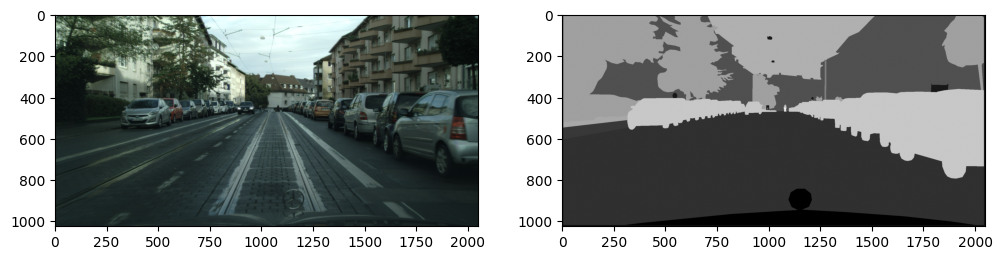

In [ ]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(cityscapes[0][0])
ax[1].imshow(cityscapes[0][1],cmap='gray')

In [ ]:
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

In [ ]:
class CityscapesMultiLabelDataset(Dataset):
    def __init__(self, root, split="train",  transform=None):
        self.image_paths = sorted(glob(os.path.join(root, f"leftImg8bit/{split}/*/*.png")))
        self.label_paths = sorted(glob(os.path.join(root, f"gtFine/{split}/*/*_gtFine_labelIds.png")))
        self.transform = transform
        self.split = split

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        label = np.array(Image.open(self.label_paths[idx]))

        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented["image"]
            label = augmented["mask"]

        # Convert resized mask to numpy array and tensor
        mask_np = np.array(label, dtype=np.uint8)
        mask_tensor = torch.as_tensor(mask_np, dtype=torch.uint8)

        # Convert mask to one-hot encoding
        mask_onehot = convert_label_to_multilabel_one_hot(mask_tensor, "cityscapes")

        return image, mask_onehot, mask_np



In [ ]:
root = "/content/cityscapes"

dataset = CityscapesMultiLabelDataset(root=root, split="train", transform=transform)
val_dataset   = CityscapesMultiLabelDataset(root=root, split="val", transform=transform)

#Taking 10% of the training set as calibration set
dataset_size = len(dataset)
train_size = int(0.9 * dataset_size)
cal_size = dataset_size - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, cal_dataset = random_split(dataset, [train_size, cal_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, drop_last=True)
cal_loader   = DataLoader(cal_dataset, batch_size=4, shuffle=False, num_workers=2, drop_last=True)


In [ ]:
print(f"Dimensione totale train split di Cityscapes: {len(dataset)}")
print(f"→ Train dataset (90%): {len(train_dataset)}")
print(f"→ Calibration dataset (10%): {len(cal_dataset)}")
print(f"→ Validation dataset: {len(val_dataset)}")


Dimensione totale train split di Cityscapes: 2975
→ Train dataset (90%): 2677
→ Calibration dataset (10%): 298
→ Validation dataset: 500


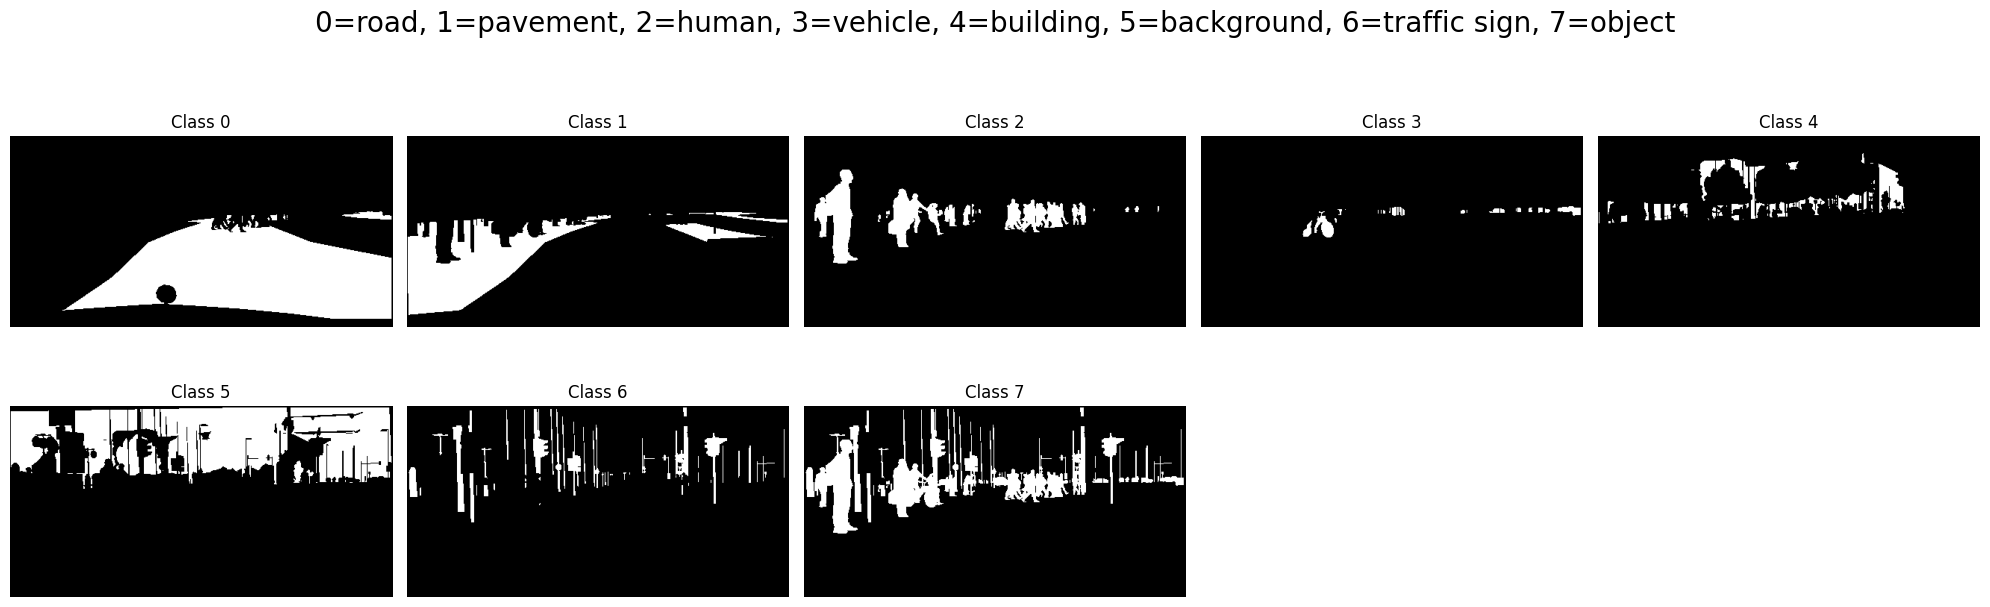

In [ ]:
image, mask_one_hot, label = train_dataset[0]

plt.figure(figsize=(20, 12))
plt.suptitle("0=road, 1=pavement, 2=human, 3=vehicle, 4=building, 5=background, 6=traffic sign, 7=object", fontsize=20)

for i in range(8):
    plt.subplot(4, 5, i + 1)
    plt.imshow(mask_one_hot[i].cpu().numpy(), cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



LOST AND FOUND DATASET

In [ ]:
zip_gt = "/content/drive/MyDrive/LostAndFound/gtCoarse.zip"
zip_img = "/content/drive/MyDrive/LostAndFound/leftImg8bit.zip"


# Estracting zip files
with zipfile.ZipFile(zip_gt, 'r') as zip_ref:
    zip_ref.extractall("/content/lostandfound")

with zipfile.ZipFile(zip_img, 'r') as zip_ref:
    zip_ref.extractall("/content/lostandfound")

In [ ]:
!ls /content/lostandfound/gtCoarse/train
!ls /content/lostandfound/leftImg8bit/train

01_Hanns_Klemm_Str_45  10_Schlossberg_9       13_Elly_Beinhorn_Str
03_Hanns_Klemm_Str_19  11_Parkplatz_Flugfeld  14_Otto_Lilienthal_Str_24
06_Galgenbergstr_40    12_Umberto_Nobile_Str
01_Hanns_Klemm_Str_45  10_Schlossberg_9       13_Elly_Beinhorn_Str
03_Hanns_Klemm_Str_19  11_Parkplatz_Flugfeld  14_Otto_Lilienthal_Str_24
06_Galgenbergstr_40    12_Umberto_Nobile_Str


In [ ]:
class LostAndFoundDataset(Dataset):
    def __init__(self, root, split='train', transform=None, encode_labels=True):
        self.image_paths = sorted(glob(os.path.join(root, f"leftImg8bit/{split}/*/*.png")))
        self.label_paths = sorted(glob(os.path.join(root, f"gtCoarse/{split}/*/*_gtCoarse_labelIds.png")))
        self.transform = transform
        self.encode_labels = encode_labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        label = np.array(Image.open(self.label_paths[idx]))

        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed["image"]
            label = transformed["mask"]


        # Convert resized mask to numpy array and tensor
        mask_np = np.array(label, dtype=np.uint8)
        mask_tensor = torch.as_tensor(mask_np, dtype=torch.uint8)


        # Convert mask to one-hot encoding
        mask_one_hot = convert_label_to_multilabel_one_hot(mask_tensor, "lostandfound")

        return image, mask_one_hot, mask_np # [3,H,W], [8,H,W], [H,W]



In [ ]:
root = "/content/lostandfound"

train_lf = LostAndFoundDataset(root=root, split="train", transform=transform)
test_lf  = LostAndFoundDataset(root=root, split="test", transform=transform)

train_loader_lf = DataLoader(train_lf, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
test_loader_lf   = DataLoader(test_lf, batch_size=4, shuffle=False, num_workers=2, drop_last=True)

In [ ]:
image, mask_one_hot, _ = train_lf[300]
print(torch.unique(mask_one_hot))


tensor([0., 1.])


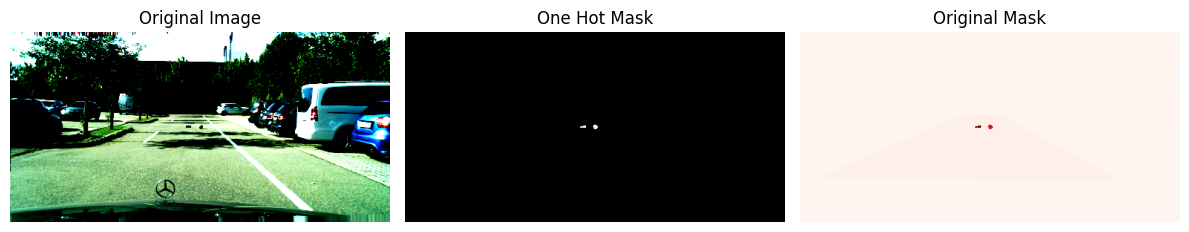

In [ ]:
image, mask_one_hot, label= train_lf[105]

# Converting the image for visualization [H, W, 3]
image_np = image.permute(1, 2, 0).cpu().numpy()
mask_np = mask_one_hot[MACRO_CLASSES["object"]].cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title("One Hot Mask")
axes[1].axis('off')

axes[2].imshow(label, cmap='Reds')
axes[2].set_title("Original Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()


ROADANOMALY DATASET

In [ ]:
!ls /content/roadanomaly

frames.zip


In [ ]:
zip_img = "/content/roadanomaly/frames.zip"


# Estracting zip files
with zipfile.ZipFile(zip_img, 'r') as zip_ref:
    zip_ref.extractall("/content/roadanomaly")

In [ ]:
class RoadAnomalyRGBOnlyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        frames_dir = os.path.join(root, "frames")

        # Finding all RGB images (.jpg)
        self.image_paths = [
            os.path.join(frames_dir, fname)
            for fname in os.listdir(frames_dir)
            if fname.endswith(".jpg") and os.path.isfile(os.path.join(frames_dir, fname))
        ]

        if not self.image_paths:
            raise RuntimeError("Images not found")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, img_path



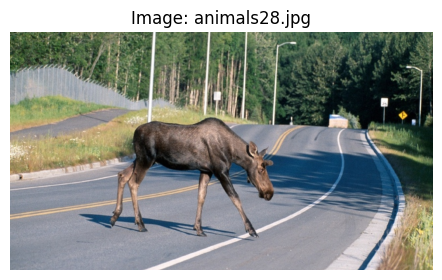

In [ ]:
# Visualizing dataset
roadanomaly = RoadAnomalyRGBOnlyDataset("/content/roadanomaly", transform=None)

img, path = roadanomaly[4]


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Image: {os.path.basename(path)}")
plt.axis("off")


plt.show()


FISHYSCAPES DATASET

In [ ]:
!cp -r "/content/drive/MyDrive/fishyscapes_2" /content/

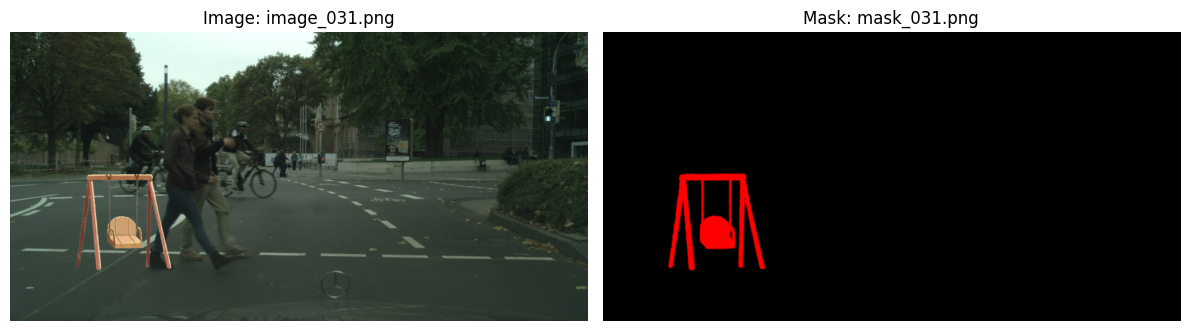

In [ ]:
image_dir = "/content/fishyscapes_2/images"
mask_dir = "/content/fishyscapes_2/masks"

# Matching the images and the masks
image_files = {f.split('_')[1].split('.')[0]: f for f in os.listdir(image_dir)}
mask_files = {f.split('_')[1].split('.')[0]: f for f in os.listdir(mask_dir)}

common_keys = list(set(image_files.keys()) & set(mask_files.keys()))
selected_key = random.choice(common_keys)

# Creating the path
image_filename = image_files[selected_key]
mask_filename = mask_files[selected_key]

image_path = os.path.join(image_dir, image_filename)
mask_path = os.path.join(mask_dir, mask_filename)

image = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image: {image_filename}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.array(mask), cmap='gray')
plt.title(f"Mask: {mask_filename}")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
class FishyscapesDataset(Dataset):
    def __init__(self, root, transform=None, encode_labels=True):
        self.image_dir = os.path.join(root, "images")
        self.mask_dir = os.path.join(root, "masks")
        self.transform = transform
        self.encode_labels = encode_labels

        # Matching the images and the masks
        image_files = {f.split('_')[1].split('.')[0]: f for f in os.listdir(self.image_dir)}
        mask_files = {f.split('_')[1].split('.')[0]: f for f in os.listdir(self.mask_dir)}
        common_keys = sorted(set(image_files.keys()) & set(mask_files.keys()))

        self.image_paths = [os.path.join(self.image_dir, image_files[k]) for k in common_keys]
        self.label_paths = [os.path.join(self.mask_dir, mask_files[k]) for k in common_keys]

    def __len__(self):
        return len(self.image_paths)



    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        label = np.array(Image.open(self.label_paths[idx]).convert("L"))
        label = (label != 0).astype(np.uint8)  # Converting 76 → 1 (obastacle pixels), 0 → 0



        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed["image"]
            label = transformed["mask"]

        mask_np = np.array(label, dtype=np.uint8)
        mask_tensor = torch.as_tensor(mask_np, dtype=torch.uint8)


        if self.encode_labels:
            mask_one_hot = convert_label_to_multilabel_one_hot(mask_tensor, "fishyscapes")
        else:
            mask_one_hot = mask_tensor

        return image, mask_one_hot, mask_np  # [3,H,W], [8,H,W], [H,W]



In [ ]:
fishy_dataset = FishyscapesDataset(
    root="/content/fishyscapes_2",
    transform=None,
    encode_labels=True
)

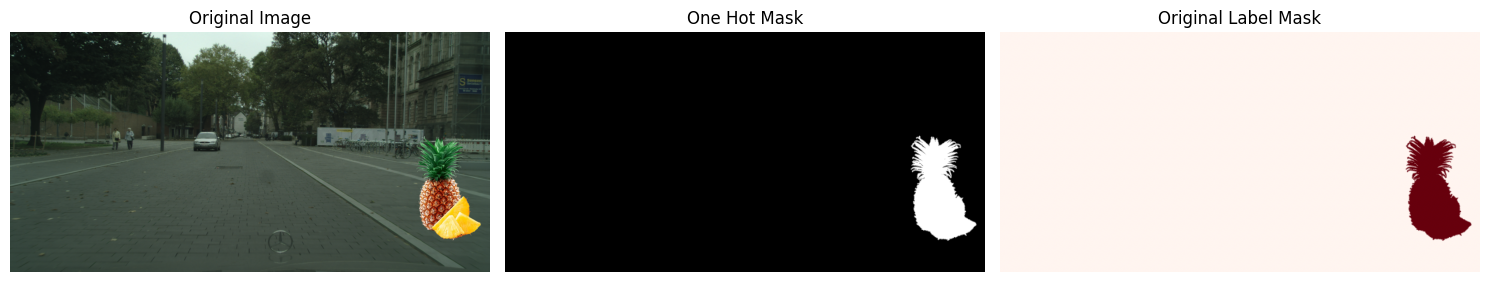

In [ ]:
# Visualization
image, mask_one_hot, label = fishy_dataset[32]


# Converting image [C,H,W] → [H,W,C]
if isinstance(image, torch.Tensor):
    image_np = image.permute(1, 2, 0).cpu().numpy()
else:
    image_np = image

anomaly_channel = mask_one_hot[MACRO_CLASSES["object"]].cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')


axes[1].imshow(anomaly_channel, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("One Hot Mask")
axes[1].axis('off')


axes[2].imshow(label, cmap='Reds')
axes[2].set_title("Original Label Mask")
axes[2].axis('off')


plt.tight_layout()
plt.show()


# Network

In [ ]:
class MultiLabelDeepLabV3(nn.Module):
    def __init__(self, n_classes=8):
        super().__init__()
        # Load pretrained model
        self.model = deeplabv3_resnet50(pretrained=True)

        # Replace classifier to output 8 channels with sigmoid
        self.model.classifier[-1] = nn.Conv2d(
            in_channels=256,
            out_channels=n_classes,
            kernel_size=1
        )

    def forward(self, x):
        x = self.model(x)['out']
        return torch.sigmoid(x)  # Apply sigmoid for multilabel outputs

In [ ]:
class BoundaryAwareBCELoss(nn.Module):
    def __init__(self, lambda_weight=3.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, pred, target, boundary_mask):
        eps = 1e-7

        # Standard BCE loss
        bce = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))
        normal_term = bce.mean()

        boundary_mask = boundary_mask.float()

        # boundary_mask has same dimensions as pred
        if boundary_mask.dim() == 3:
            boundary_mask = boundary_mask.unsqueeze(1)

        # Expansion to (B, C, H, W)
        boundary_mask = boundary_mask.expand(-1, pred.shape[1], -1, -1)

        # Boundary aware BCE loss
        boundary_bce = bce * boundary_mask
        num_boundary_pixels = boundary_mask.sum(dim=(1, 2, 3)).clamp(min=1.0)
        boundary_loss = boundary_bce.sum(dim=(1, 2, 3)) / num_boundary_pixels
        boundary_term = boundary_loss.mean()

        return normal_term + self.lambda_weight * boundary_term

In [ ]:
model = MultiLabelDeepLabV3(n_classes=8).to('cuda')

criterion = BoundaryAwareBCELoss(lambda_weight=3.0)

# Parameters
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0001
power = 0.9
num_epochs = 15
boundary_iterations = 5

optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)

# Calculate max iterations for poly schedule
max_iter = num_epochs * len(train_loader)
current_iter = 0

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0
early_stop = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 220MB/s]


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # ---- TRAINING STEP ----
    for imgs, masks, original_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, masks = imgs.to('cuda'), masks.to('cuda')
        optimizer.zero_grad()
        preds = model(imgs)
        # Get boundary masks
        boundary_masks = get_boundary_mask_batch(original_mask, iterations=boundary_iterations).detach().to('cuda')
        loss = criterion(preds, masks, boundary_masks)
        loss.backward()
        optimizer.step()

        # Poly LR update
        current_iter += 1
        lr = initial_lr * (1 - current_iter / max_iter) ** power
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # ---- VALIDATION STEP ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks, original_mask in val_loader:
            imgs, masks = imgs.to('cuda'), masks.to('cuda')
            preds = model(imgs)
            boundary_masks = get_boundary_mask_batch(original_mask, iterations=boundary_iterations).detach().to('cuda')
            loss = criterion(preds, masks, boundary_masks)
            val_loss += loss.item()
        torch.cuda.empty_cache()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {lr:.6f}")

    # ---- EARLY STOPPING ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "final_model.pth")
        print("Model Saved")
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping used")
            early_stop = True
            break


Epoch 1: 100%|██████████| 669/669 [02:33<00:00,  4.35it/s]


Epoch [1/15] | Train Loss: 0.4283 | Val Loss: 0.3205 | LR: 0.009398
Model Saved


Epoch 2: 100%|██████████| 669/669 [02:30<00:00,  4.46it/s]


Epoch [2/15] | Train Loss: 0.2832 | Val Loss: 0.2878 | LR: 0.008792
Model Saved


Epoch 3: 100%|██████████| 669/669 [02:28<00:00,  4.49it/s]


Epoch [3/15] | Train Loss: 0.2523 | Val Loss: 0.2728 | LR: 0.008181
Model Saved


Epoch 4: 100%|██████████| 669/669 [02:28<00:00,  4.50it/s]


Epoch [4/15] | Train Loss: 0.2331 | Val Loss: 0.2662 | LR: 0.007564
Model Saved


Epoch 5: 100%|██████████| 669/669 [02:29<00:00,  4.48it/s]


Epoch [5/15] | Train Loss: 0.2198 | Val Loss: 0.2649 | LR: 0.006943
Model Saved


Epoch 6: 100%|██████████| 669/669 [02:28<00:00,  4.52it/s]


Epoch [6/15] | Train Loss: 0.2090 | Val Loss: 0.2595 | LR: 0.006314
Model Saved


Epoch 7: 100%|██████████| 669/669 [02:30<00:00,  4.46it/s]


Epoch [7/15] | Train Loss: 0.2001 | Val Loss: 0.2588 | LR: 0.005679
Model Saved


Epoch 8: 100%|██████████| 669/669 [02:28<00:00,  4.50it/s]


Epoch [8/15] | Train Loss: 0.1940 | Val Loss: 0.2570 | LR: 0.005036
Model Saved


Epoch 9: 100%|██████████| 669/669 [02:28<00:00,  4.49it/s]


Epoch [9/15] | Train Loss: 0.1879 | Val Loss: 0.2566 | LR: 0.004384
Model Saved


Epoch 10: 100%|██████████| 669/669 [02:29<00:00,  4.47it/s]


Epoch [10/15] | Train Loss: 0.1824 | Val Loss: 0.2603 | LR: 0.003720


Epoch 11: 100%|██████████| 669/669 [02:27<00:00,  4.55it/s]


Epoch [11/15] | Train Loss: 0.1788 | Val Loss: 0.2573 | LR: 0.003043


Epoch 12: 100%|██████████| 669/669 [02:26<00:00,  4.56it/s]


Epoch [12/15] | Train Loss: 0.1753 | Val Loss: 0.2589 | LR: 0.002349
Early Stopping used


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/final_model.pth")
print("Modello salvato su Google Drive")

Modello salvato su Google Drive


-----------------------------------FINETUNING-----------------------------------

In [ ]:
#Loading of the Trained model
model = MultiLabelDeepLabV3(n_classes=8).to('cuda')
model.load_state_dict(torch.load("/content/drive/MyDrive/final_model.pth"))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
class BoundaryAwareBCELossFineTuning(nn.Module):
    def __init__(self, lambda_weight=3.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, pred, target, boundary_mask):
        eps = 1e-7

        bce = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))

        # Create a mask: pixels with at least one GT class > 0
        #Shape: (B, H, W)
        valid_pixel_mask = (target.sum(dim=1) > 0).float()

        # Expand to match shape (B, C, H, W)
        valid_pixel_mask = valid_pixel_mask.unsqueeze(1).expand_as(target)

        # Apply the pixel mask
        bce = bce * valid_pixel_mask
        num_valid_pixels = valid_pixel_mask.sum(dim=(1, 2, 3)).clamp(min=1.0)
        normal_loss = bce.sum(dim=(1, 2, 3)) / num_valid_pixels
        normal_term = normal_loss.mean()

        if boundary_mask.dim() == 3:
            boundary_mask = boundary_mask.unsqueeze(1)
        boundary_mask = boundary_mask.expand_as(target)

        #Boundary aware BCE loss
        boundary_bce = bce * boundary_mask
        num_boundary_pixels = (boundary_mask * valid_pixel_mask).sum(dim=(1, 2, 3)).clamp(min=1.0)
        boundary_loss = boundary_bce.sum(dim=(1, 2, 3)) / num_boundary_pixels
        boundary_term = boundary_loss.mean()

        return normal_term + self.lambda_weight * boundary_term

In [ ]:
# Reinitialize optimizer
fine_tune_lr = 1e-4
momentum = 0.9
weight_decay = 0.0001
optimizer = optim.SGD(model.parameters(), lr=fine_tune_lr, momentum=momentum, weight_decay=weight_decay)

boundary_iterations_ft = 1  # Number of iterations for boundary mask computation

# Criterion
criterion = BoundaryAwareBCELossFineTuning(lambda_weight=3.0)

# Early Stopping
patience = 3
counter = 0
early_stop = False

# Fine-tuning parameters
num_finetune_epochs = 5
power = 0.9

# Calculate max iterations for poly schedule
max_iter = num_finetune_epochs * len(train_loader_lf)
current_iter = 0


In [ ]:
# Fine-tuning loop
for epoch in range(num_finetune_epochs):
    model.train()
    running_loss = 0.0

    # ---- Fine-tuning Step ----
    for imgs, masks, original_mask in tqdm(train_loader_lf, desc=f"Fine-tune Epoch {epoch+1}"):
        imgs, masks = imgs.to('cuda'), masks.to('cuda')
        optimizer.zero_grad()

        preds = model(imgs)
        boundary_masks = get_boundary_mask_batch(original_mask, iterations=boundary_iterations).detach().to('cuda')

        loss = criterion(preds, masks, boundary_masks)
        loss.backward()
        optimizer.step()

        # Poly learning rate update
        current_iter += 1
        lr = fine_tune_lr * (1 - current_iter / max_iter) ** power
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader_lf)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks, original_mask in val_loader:
            imgs, masks = imgs.to('cuda'), masks.to('cuda')
            preds = model(imgs)
            boundary_masks = get_boundary_mask_batch(original_mask, iterations=boundary_iterations_ft).detach().to('cuda')
            loss = criterion(preds, masks, boundary_masks)
            val_loss += loss.item()
        torch.cuda.empty_cache()

    avg_val_loss = val_loss / len(test_loader_lf)
    print(f"[Fine-tune Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {lr:.6f}")


    # ---- EARLY STOPPING ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "finetuned_model.pth")
        print("Model Saved")
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping used")
            early_stop = True
            break


Fine-tune Epoch 1: 100%|██████████| 259/259 [00:57<00:00,  4.52it/s]


[Fine-tune Epoch 1] Train Loss: 0.0530 | Val Loss: 0.1112 | LR: 0.000082
Model Saved


Fine-tune Epoch 2: 100%|██████████| 259/259 [00:56<00:00,  4.59it/s]


[Fine-tune Epoch 2] Train Loss: 0.0380 | Val Loss: 0.1158 | LR: 0.000063


Fine-tune Epoch 3: 100%|██████████| 259/259 [00:55<00:00,  4.69it/s]


[Fine-tune Epoch 3] Train Loss: 0.0356 | Val Loss: 0.1188 | LR: 0.000044


Fine-tune Epoch 4: 100%|██████████| 259/259 [00:56<00:00,  4.62it/s]


[Fine-tune Epoch 4] Train Loss: 0.0340 | Val Loss: 0.1179 | LR: 0.000023
Early Stopping used


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/finetuned_model.pth")
print("Modello salvato su Google Drive")

Modello salvato su Google Drive


# Test

In [ ]:
#Loading of the Finetuned model
finetuned_model = MultiLabelDeepLabV3(n_classes=8).to('cuda')
finetuned_model.load_state_dict(torch.load("/content/drive/MyDrive/finetuned_model.pth"))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 189MB/s]


<All keys matched successfully>

In [ ]:
calibration_scores = []

KNOWN_OBJECT_CLASSES = [2, 3, 6]  # human, vehicle, pole


finetuned_model.eval()
for images_batch, labels_batch, _ in cal_loader:
    images_batch = images_batch.to('cuda')
    labels_batch = labels_batch.to('cuda')  # shape: (B, C, H, W)

    with torch.no_grad():
        output = finetuned_model(images_batch)  # shape: (B, 8, H, W), sigmoid
        nonconformity_scores = unknown_objectness_score(output)

    # nonconformity_scores shape: (B, H, W)
    for b in range(images_batch.size(0)):
        lbl = labels_batch[b]  # (C, H, W)
        non_conf_score = nonconformity_scores[b]  # (H, W)

        mask = lbl[KNOWN_OBJECT_CLASSES].any(dim=0) # (H, W) true for pixels belonging to known objects


        # Apply mask and extract corresponding unknown objectness scores
        selected_scores = non_conf_score[mask]

        calibration_scores.extend(selected_scores.cpu().numpy())

calibration_scores = np.sort(np.array(calibration_scores))

if len(calibration_scores) == 0:
    raise ValueError("Calibration scores empty!")

In [ ]:
alpha = 0.01

threshold = np.quantile(calibration_scores, 1 - alpha)
print(f"Calibration threshold for alpha={alpha}: {threshold:.4f}")

Calibration threshold for alpha=0.01: 0.3299


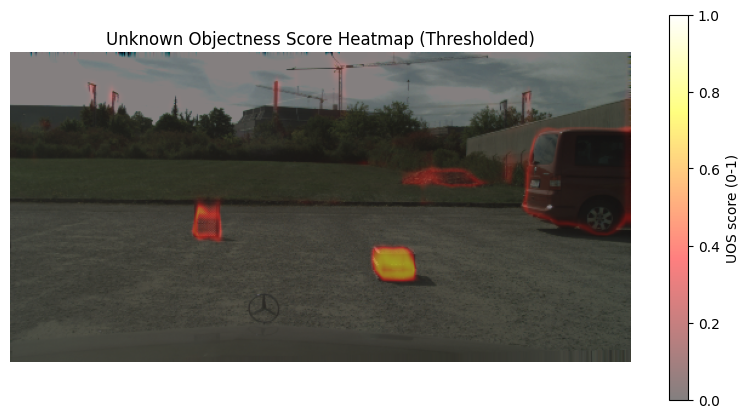

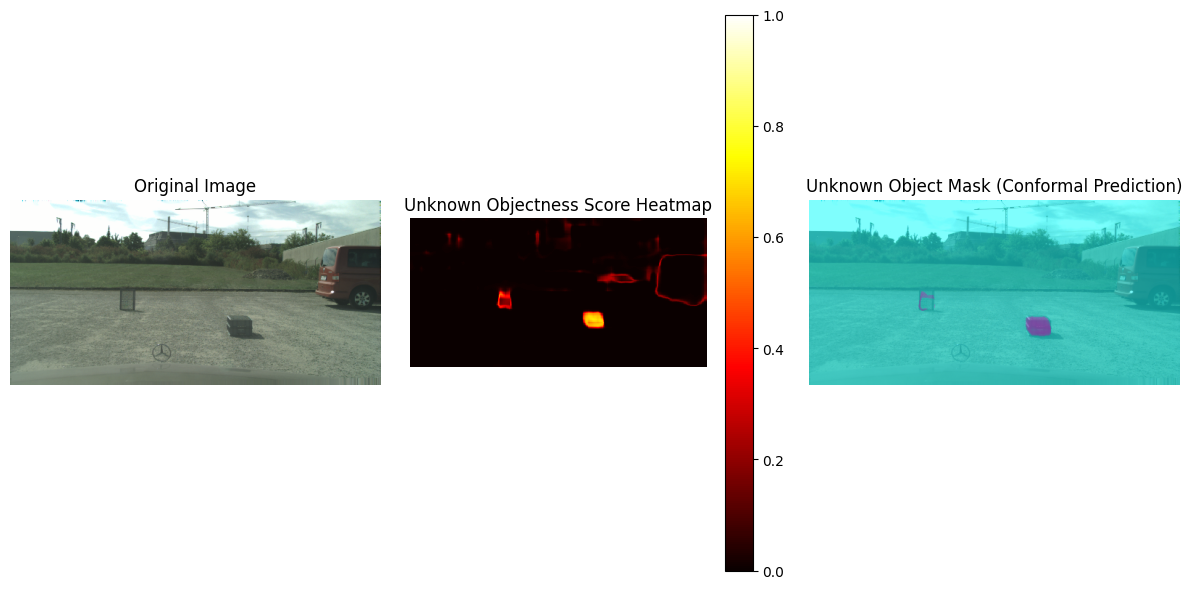

In [ ]:
image, label, _ = train_lf[304]
finetuned_model.eval()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return (tensor * std + mean).clamp(0, 1)

with torch.no_grad():
    output = finetuned_model(image.unsqueeze(0).to('cuda'))
    uos = unknown_objectness_score(output)[0]
    pred = output[0]


# Visualize the heatmap superposed on the image
img_test = denormalize(image)

uos_heatmap(img_test, uos, threshold=0.0, alpha_val=0.5)



# Visualize the UOS with the CP threshold
visualize_uos_with_conformal(img_test, uos, threshold)



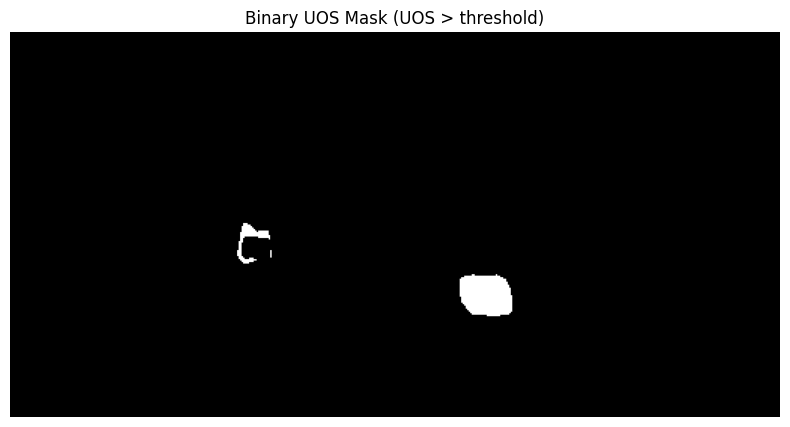

In [ ]:
uos_binary = (uos > threshold).cpu().numpy().astype(np.uint8)

uos_mask_image = Image.fromarray(uos_binary * 255)

#uos_mask_image.save("uos_mask_binary.png")

plt.figure(figsize=(10, 5))
plt.imshow(uos_mask_image, cmap="gray")
plt.title("Binary UOS Mask (UOS > threshold)")
plt.axis("off")
plt.show()

Class distribution in prediction:
Class 0: 43411 pixels
Class 1: 11365 pixels
Class 2: 38 pixels
Class 3: 13724 pixels
Class 4: 29417 pixels
Class 5: 30102 pixels
Class 6: 3015 pixels


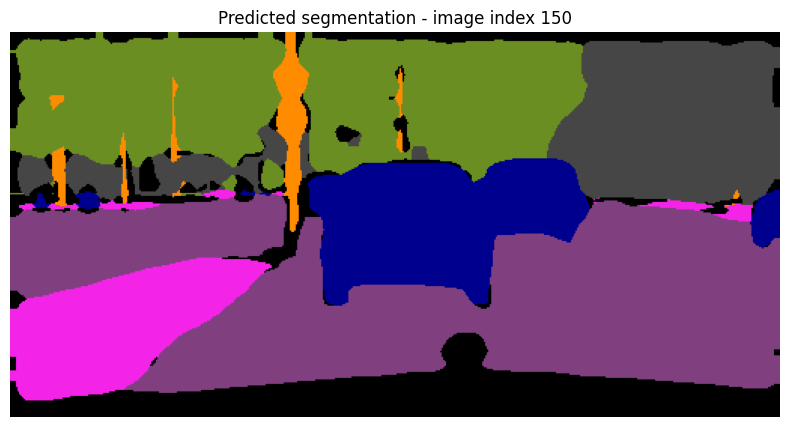

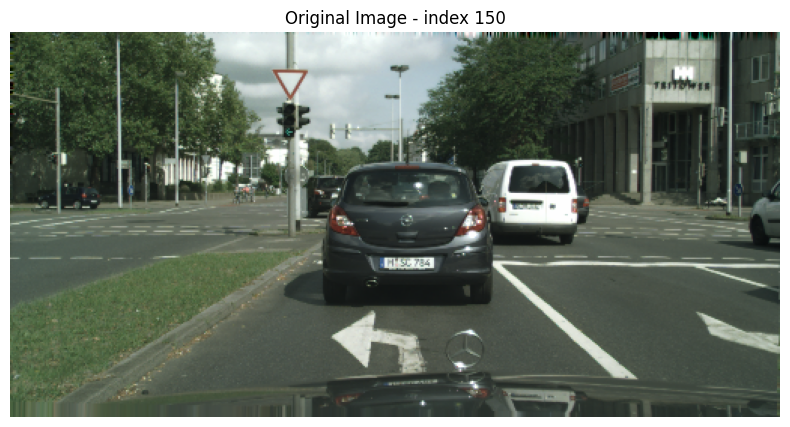

In [ ]:
#Visualizing segmentation
idx = 150

image, target_onehot, _ = train_dataset[idx]


image_batch = image.unsqueeze(0).to('cuda')  # [1, 3, H, W]

finetuned_model.eval()
with torch.no_grad():
    preds = finetuned_model(image_batch)  # [1, 8, H, W]


pred_classes = preds[:, :7].argmax(dim=1)[0].cpu().numpy()  # [H, W]

unique, counts = np.unique(pred_classes, return_counts=True)
print("Class distribution in prediction:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} pixels")

class_scores = preds[0, :7]  # [C, H, W]
unknown_scores = torch.prod(1 - class_scores, dim=0)  # [H, W]
unknown_mask = (unknown_scores > threshold).cpu().numpy()


h, w = pred_classes.shape
color_img = np.zeros((h, w, 3), dtype=np.uint8)

for class_idx, color in enumerate(CLASS_INDEX_COLORS):
    color_img[pred_classes == class_idx] = color

color_img[unknown_mask] = (0, 0, 0)  # black


plt.figure(figsize=(10, 5))
plt.imshow(color_img)
plt.title(f"Predicted segmentation - image index {idx}")
plt.axis("off")
plt.show()


original_img_np = image_batch[0].cpu().permute(1, 2, 0).numpy()  # [H, W, 3]


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
original_img_np = original_img_np * std + mean
original_img_np = np.clip(original_img_np, 0, 1)

plt.figure(figsize=(10, 5))
plt.imshow(original_img_np)
plt.title(f"Original Image - index {idx}")
plt.axis("off")
plt.show()


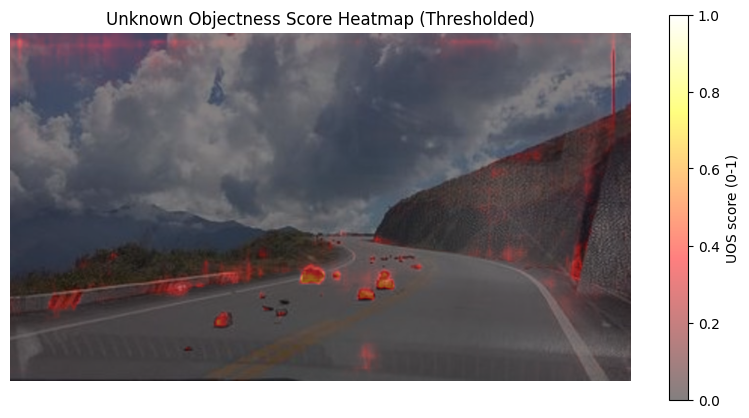

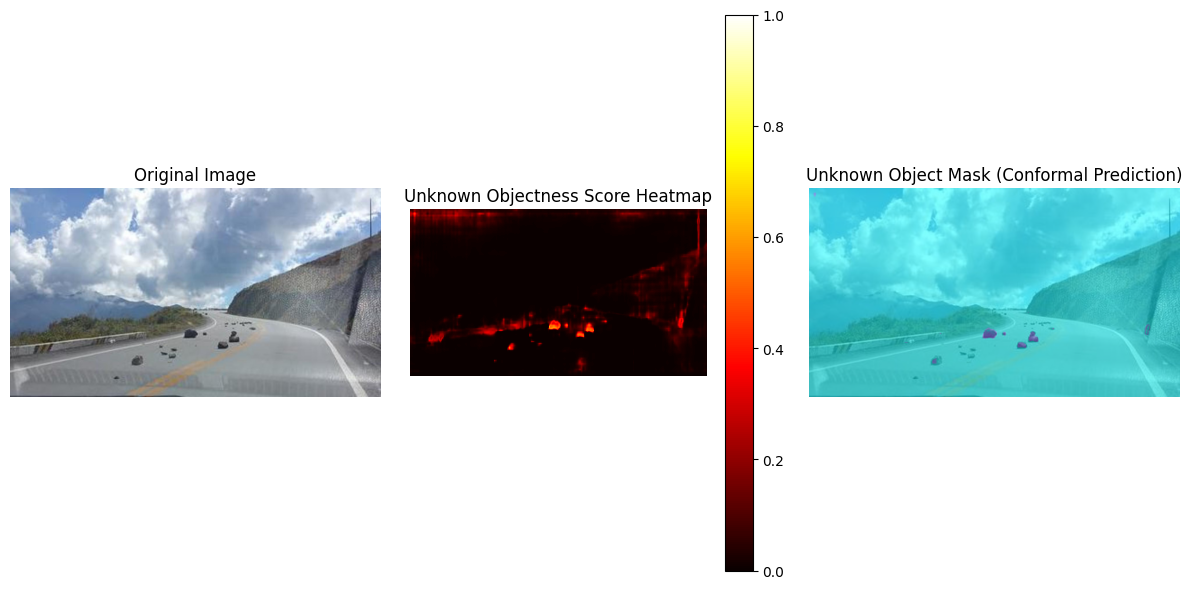

In [ ]:
image_np, path = roadanomaly[18]

image = to_tensor(image_np)  # [3, H, W], values in [0, 1]
image = normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


finetuned_model.eval()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return (tensor * std + mean).clamp(0, 1)

with torch.no_grad():
    output = finetuned_model(image.unsqueeze(0).to('cuda'))
    uos = unknown_objectness_score(output)[0]
    pred = output[0]



# Visualize the heatmap superposed on the image
img_test = denormalize(image)
uos_heatmap(img_test, uos, threshold=0.0, alpha_val=0.5)



# Visualize the UOS with the CP threshold
visualize_uos_with_conformal(img_test, uos,  threshold)

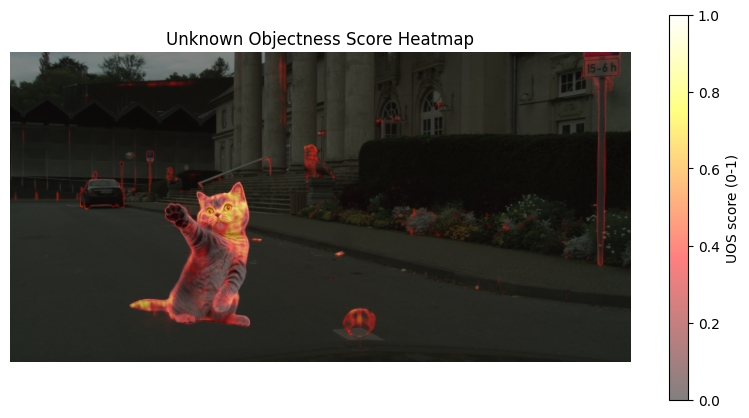

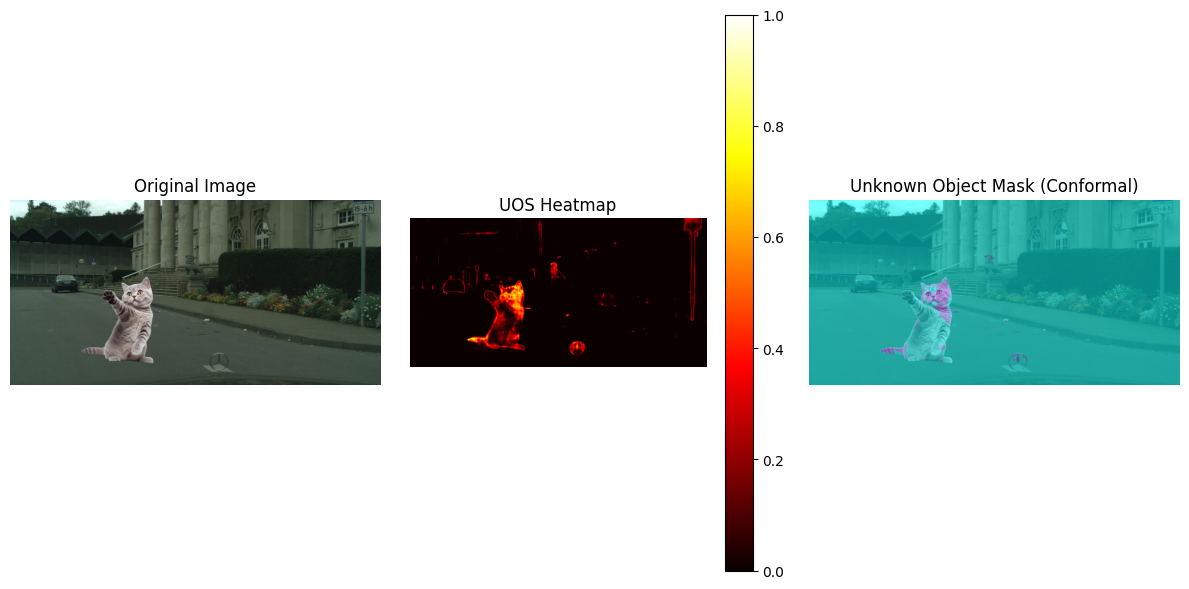

In [ ]:
# Prendi immagine da FishyscapesDataset
image_np, mask_one_hot, label = fishy_dataset[7]

image = to_tensor(image_np)  # [3, H, W], values in [0, 1]
image = normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


finetuned_model.eval()


def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return (tensor * std + mean).clamp(0, 1)

# Inference
with torch.no_grad():
    output = finetuned_model(image.unsqueeze(0).to('cuda'))
    uos = unknown_objectness_score(output)[0]  # [H, W]
    pred = output[0]


img_test = denormalize(image)

uos_heatmap(img_test, uos, threshold=0.0, alpha_val=0.5)

visualize_uos_with_conformal(img_test, uos, threshold)


# Metrics

Detection performance metrics

In [ ]:
# Performance metrics on Cityscapes
metrics = evaluate_detection_performance_metrics(finetuned_model, val_loader)
for key, value in metrics.items():
    print(f"  {key}: {value:.4f}")

  pixel_accuracy: 0.8316
  mean_iou: 0.5951
  mean_f1: 0.7176


Uncertainty metrics

In [ ]:
# Uncertainty metrics for LostAndFound
dictionary_metrics_lostandfound = evaluate_uncertainty_metrics(finetuned_model, test_loader_lf, class_index=7)

print(f"Average Precision (AP): {dictionary_metrics_lostandfound['AP']:.4f}")
print(f"FPR@95TPR: {dictionary_metrics_lostandfound['FPR95']:.4f}")
print(f"AUROC: {dictionary_metrics_lostandfound['AUROC']:.4f}")

Average Precision (AP): 0.1668
FPR@95TPR: 0.4197
AUROC: 0.9229


In [ ]:
benchmark_loader_c = DataLoader(
    fishy_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
# Uncertainty metrics for Fishyscapes
dictionary_metrics_roadanomaly = evaluate_uncertainty_metrics_2(finetuned_model, benchmark_loader_c, class_index=7)

print(f"Average Precision (AP): {dictionary_metrics_roadanomaly['AP']:.4f}")
print(f"FPR@95TPR: {dictionary_metrics_roadanomaly['FPR95']:.4f}")
print(f"AUROC: {dictionary_metrics_roadanomaly['AUROC']:.4f}")

Average Precision (AP): 0.0295
FPR@95TPR: 1.0000
AUROC: 0.4014
